In [9]:
%matplotlib inline

In [17]:

import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import signal
import pickle

import os
import pdb
from loren_frank_data_processing import (make_epochs_dataframe,
                                         make_neuron_dataframe)
from src.parameters import (ANIMALS, MIN_N_NEURONS, _BRAIN_AREAS)

from scripts.run_by_epoch import clusterless_thetasweeps
from tqdm.auto import tqdm

from scipy.stats import spearmanr, pearsonr
from scipy.signal import hilbert

In [11]:
def get_steps(Replay_traj, timeb=1):
    '''
    Get the levy exponent for replay trajectory
    Input 
        (dictionary): Replay_traj
        (int): time bin
    Output:
        (numpy array): all_steps for all ripple events
    
    '''
    #initialze an empty numpy array
    all_steps = []

    keys = Replay_traj.keys()
    for key in keys:
        #get the replay trajectory for each ripple events
        ripple_traj = Replay_traj[key]
        traj_step = np.abs(np.diff(ripple_traj[::timeb]))
        #concatenate the steps for all ripple events
        all_steps = np.concatenate((all_steps, traj_step))
    
    return all_steps

In [30]:
#log-log plot of the average step size against time bins
def get_diffusion_exponent(Replay_traj, plot=False): 
    
    #return plt
    all_timebins = np.arange(1,20,1)
    all_avg_steps = []
    for timeb in all_timebins:
        all_steps = get_steps(Replay_traj, timeb)
        #get the average step size for each time bin
        avg_step = np.mean(all_steps)
        all_avg_steps.append(avg_step)
    #get the slope of the log-log plot
    slope, intercept = np.polyfit(np.log(all_timebins), np.log(all_avg_steps), 1)
    
    #print('The slope of the log-log plot is %.2f'%slope)
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(3,3))
        #plot the log-log plot and add the slope as a lagend
        ax.plot(all_timebins, all_avg_steps, 'o', color='black')
        ax.plot(all_timebins, np.exp(intercept)*all_timebins**slope, 'r-', label='slope = %.2f'%slope)  
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Time bins')
        ax.set_ylabel('Average step size')
        ax.legend()
        #set both ticks to [0,10]
        ax.set_xticks([1,10])
        ax.set_yticks([1,10])
        return fig, ax, slope
    else:
        return slope
       

In [13]:
def bandpassfilter(data, lowcut=5, highcut=11, fs=500):
    """
    band pass filter of the signal
    Created by Zilong, 30/08/2021
    """
    lowcut = 5
    highcut = 11
    order = 5
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype="band")
    filtereddata = signal.filtfilt(b, a, data)

    return filtereddata

In [14]:
def get_zero_phase(filtered_lfp):
    """
    get the zero phase of the filtered lfp using hilbert transform
    """
    filtered_lfp = filtered_lfp.values.squeeze()
    analytic_signal = hilbert(filtered_lfp)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    # wrap the instantaneous_phase to -pi and pi
    instantaneous_phase = np.mod(instantaneous_phase + np.pi, 2 * np.pi) - np.pi
    # find phase of 0 and mark all of them as a red point on the plot
    zero_phase = np.where(
        np.logical_and(instantaneous_phase > -3.15, instantaneous_phase < -3.0)
    )[0]

    # if successive zero phase is less than 10, only keep the first one
    splits = np.split(zero_phase, np.where(np.diff(zero_phase) > 10)[0] + 1)
    zero_phase_index = np.array([split[0] for split in splits])

    return zero_phase_index

In [15]:
def get_sweep_amp_each_theta_cycle(lfp0_in_running, sweeps_dist_in_running):
    """
    get the amplitude of each sweep in each theta cycle
    Input:
        lfp0_in_running: the filtered lfp in running
        sweeps_dist_in_running: the mental distance of each sweep in running
    """
    # get the zero phase index
    zero_phase_index = get_zero_phase(lfp0_in_running)
    
    #if first element in zero_phase_index is 0, remove it
    if zero_phase_index[0] == 0:
        zero_phase_index = zero_phase_index[1:]

    # split the sweeps_dist_in_running according to the zero phase index
    # and extract the largest sweep_dist in each theta cycle
    splits = np.split(sweeps_dist_in_running, zero_phase_index)

    sweep_amp_each_theta_cycle = np.array([np.max(split) for split in splits])

    #print(sweep_amp_each_theta_cycle)
    
    return np.mean(sweep_amp_each_theta_cycle)

In [18]:
epoch_info = make_epochs_dataframe(ANIMALS)
neuron_info = make_neuron_dataframe(ANIMALS)

neuron_info = neuron_info.loc[
(neuron_info.type == 'principal') &
(neuron_info.numspikes > 100) &
neuron_info.area.isin(_BRAIN_AREAS)]

n_neurons = (neuron_info
                .groupby(['animal', 'day', 'epoch'])
                .neuron_id
                .agg(len)
                .rename('n_neurons')
                .to_frame())

epoch_info = epoch_info.join(n_neurons)
is_w_track = (epoch_info.environment
                .isin(['TrackA', 'TrackB', 'WTrackA', 'WTrackB']))

## Analysis for animal bon

In [ ]:

is_animal = epoch_info.index.isin(['bon'], level='animal')

valid_epochs = (is_w_track &
                (epoch_info.n_neurons > MIN_N_NEURONS) &
                is_animal
                )

DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

sweep_len1 = []
replay_ratio1 = []
exponent1 = []
for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
    animal, day, epoch = epoch_key
    print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
    
    #1, LOAD THETA SWEEPS RESULTS
    
    #load the classifier results
    cv_classifier_clusterless_results = xr.open_dataset(os.path.join(DATA_DIR, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc'))
    #load the data with pickle
    with open(os.path.join(DATA_DIR, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_speed_info.pkl'), 'rb') as f:
        speed = pickle.load(f)
        speed =speed.values
    
    is_running = speed > 10
        
    #load lfp
    with open(os.path.join(DATA_DIR, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_data.pkl'), 'rb') as f:
        data = pickle.load(f)
        
    lfp = (
        data["lfps"]
        .reset_index(drop=True)
        .set_index(data["lfps"].index / np.timedelta64(1, "s"))
    )
    
    # add band passs filter to lfp.iloc[:,0], using band between 5-11Hz
    lfp0 = bandpassfilter(lfp.iloc[:, 0], lowcut=5, highcut=11, fs=500)
    # group the lfp0 into dataframe with time index
    lfp0 = pd.DataFrame(lfp0, index=lfp.index)
    
    lfp0_in_running = lfp0[is_running]

    sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

    mean_sweep_amp = get_sweep_amp_each_theta_cycle(lfp0_in_running, sweeps_dist_in_running)
    print(f'Average sweep amplitude in running: {mean_sweep_amp}')
    
    sweep_len1.append(mean_sweep_amp)
    
    #remove those values more than 30 in sweeps_dist_in_running
    #sweeps_dist_in_running = sweeps_dist_in_running.where(sweeps_dist_in_running<30)
    
    #find all the local peaks in sweeps_dist_in_running and average all the peaks 

        
    # #print the average sweep length
    # print(f'Average sweep length: {np.mean(sweeps_dist_in_running)}')
    # sweep_len1.append(np.mean(sweeps_dist_in_running).values)
    
    #2, LOAD REPLAY RESULTS
    #load the dictionary from the 'ReplayTrajectories' folder under PROCESSED_DATA_DIR using pickle
    with open(os.path.join(DATA_DIR, 'ReplayTrajectories', f'{animal}_{day:02d}_{epoch:02d}_traj.pkl'), 'rb') as f:
        Replay_traj = pickle.load(f)
        
    fig, ax, slope = get_exponent(Replay_traj, plot=True)
    exponent1.append(slope)
    #show the plot
    plt.show()
    
    steps = get_steps(Replay_traj, timeb=1)
    
    #Count the ratio of steps that are out of three standard deviations
    #get the mean and standard deviation of the steps
    mean = np.mean(steps)
    std = np.std(steps)
    #get the number of steps that are out of three standard deviations
    n_outlier = np.sum(np.abs(steps-mean)>2*std)
    #get the ratio and print mean and standard deviation as well
    ratio = n_outlier/len(steps)
    print(f'Ratio of steps that are out of two standard deviations: {ratio}')
    
    replay_ratio1.append(ratio)
        
        

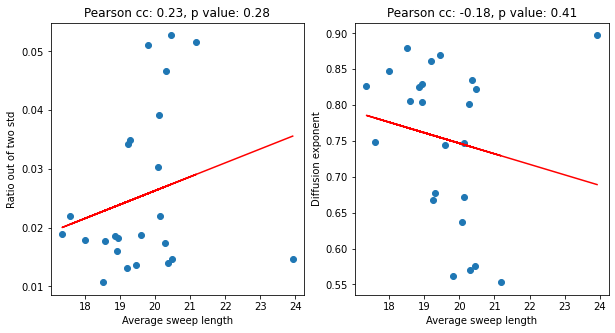

In [128]:
#plot sweep_len against replay_ratio, and against exponent1
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(np.array(sweep_len1), np.array(replay_ratio1))
plt.xlabel('Average sweep length')
plt.ylabel('Ratio out of two std')
#add linear fit line to the plot using numpy.polyfit
slope, intercept = np.polyfit(np.array(sweep_len1), np.array(replay_ratio1), 1)
plt.plot(np.array(sweep_len1), np.array(sweep_len1)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len1), np.array(replay_ratio1))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))
    
plt.subplot(1,2,2)
plt.scatter(np.array(sweep_len1), np.array(exponent1))
plt.xlabel('Average sweep length')
plt.ylabel('Diffusion exponent')
#add linear fit line to the plot
slope, intercept = np.polyfit(np.array(sweep_len1), np.array(exponent1), 1)
plt.plot(np.array(sweep_len1), np.array(sweep_len1)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len1), np.array(exponent1))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))

plt.show()
    

In [ ]:
is_animal = epoch_info.index.isin(['bon'], level='animal')

valid_epochs = (is_w_track &
                (epoch_info.n_neurons > MIN_N_NEURONS) &
                is_animal
                )

DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

sweep_len0 = []
replay_ratio0 = []
exponent0 = []
for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
    animal, day, epoch = epoch_key
    print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
    
    #1, LOAD THETA SWEEPS RESULTS
    
    #load the classifier results
    cv_classifier_clusterless_results = xr.open_dataset(os.path.join(DATA_DIR, 'ThetaSweepTrajectories_all', f'{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc'))
    #load the data with pickle
    with open(os.path.join(DATA_DIR, 'ThetaSweepTrajectories_all', f'{animal}_{day:02d}_{epoch:02d}_speed_info.pkl'), 'rb') as f:
        speed = pickle.load(f)
        speed = speed.values
        
    #get the average sweep length
    #extract speed from data and threshold it with 10 cm/s
    is_running = speed > 4

    sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

    #print the average sweep length
    print(f'Average sweep length: {np.mean(sweeps_dist_in_running)}')
    sweep_len0.append(np.mean(sweeps_dist_in_running).values)
    
    #2, LOAD REPLAY RESULTS
    #load the dictionary from the 'ReplayTrajectories' folder under PROCESSED_DATA_DIR using pickle
    with open(os.path.join(DATA_DIR, 'ReplayTrajectories_all', f'{animal}_{day:02d}_{epoch:02d}_traj.pkl'), 'rb') as f:
        Replay_traj = pickle.load(f)
        
    #fig, ax, slope = get_exponent(Replay_traj, plot=True)
    slope = get_exponent(Replay_traj, plot=False)
    print(f'The slope of the log-log plot is %.2f'%slope)
    exponent0.append(slope)
    #plt.show()
        
    steps = get_steps(Replay_traj, timeb=1)
    
    #Count the ratio of steps that are out of three standard deviations
    #get the mean and standard deviation of the steps
    mean = np.mean(steps)
    std = np.std(steps)
    #get the number of steps that are out of three standard deviations
    n_outlier = np.sum(np.abs(steps-mean)>2*std)
    #get the ratio and print mean and standard deviation as well
    ratio = n_outlier/len(steps)
    print(f'Ratio of steps that are out of two standard deviations: {ratio}')
    
    replay_ratio0.append(ratio)
        
        

In [ ]:
#plot sweep_len against replay_ratio, and against exponent1
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(np.array(sweep_len0), np.array(replay_ratio0))
plt.xlabel('Average sweep length')
plt.ylabel('Ratio out of two std')
#add linear fit line to the plot using numpy.polyfit
slope, intercept = np.polyfit(np.array(sweep_len0), np.array(replay_ratio0), 1)
plt.plot(np.array(sweep_len0), np.array(sweep_len0)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len0), np.array(replay_ratio0))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))
    
plt.subplot(1,2,2)
plt.scatter(np.array(sweep_len0), np.array(exponent0))
plt.xlabel('Average sweep length')
plt.ylabel('Diffusion exponent')
#add linear fit line to the plot
slope, intercept = np.polyfit(np.array(sweep_len0), np.array(exponent0), 1)
plt.plot(np.array(sweep_len0), np.array(sweep_len0)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len0), np.array(exponent0))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))

plt.show()

## Analysis for animal con

In [19]:
is_animal = epoch_info.index.isin(['con'], level='animal')

valid_epochs = (is_w_track &
                (epoch_info.n_neurons > MIN_N_NEURONS) &
                is_animal
                )

DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

DATA_DIR = '/media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis'

sweep_len1 = []
replay_ratio1 = []
exponent1 = []
ave_speed1 = []
for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
    animal, day, epoch = epoch_key
    print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
    
    #1, LOAD THETA SWEEPS RESULTS
    
    #load the classifier results
    cv_classifier_clusterless_results = xr.open_dataset(os.path.join(DATA_DIR, 'ThetaSweepTrajectories_all', f'{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc'))
    #load the data with pickle
    with open(os.path.join(DATA_DIR, 'ThetaSweepTrajectories_all', f'{animal}_{day:02d}_{epoch:02d}_speed_info.pkl'), 'rb') as f:
        speed = pickle.load(f)
        speed = speed.values
        
    #get the average sweep length
    #extract speed from data and threshold it with 10 cm/s
    is_running = speed > 4

    sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

    #print the average sweep length
    print(f'Average sweep length: {np.mean(sweeps_dist_in_running)}')
    
    if np.mean(sweeps_dist_in_running).values > 40:
        continue
    
    #get mean speed with speed < 4
    mean_speed = np.mean(speed[speed<4])
    ave_speed1.append(mean_speed)
    
    sweep_len1.append(np.mean(sweeps_dist_in_running).values)
    
    #2, LOAD REPLAY RESULTS
    #load the dictionary from the 'ReplayTrajectories' folder under PROCESSED_DATA_DIR using pickle
    with open(os.path.join(DATA_DIR, 'ReplayTrajectories_all', f'{animal}_{day:02d}_{epoch:02d}_traj.pkl'), 'rb') as f:
        Replay_traj = pickle.load(f)
        
    #fig, ax, slope = get_exponent(Replay_traj, plot=True)
    slope = get_exponent(Replay_traj, plot=False)
    print(f'The slope of the log-log plot is %.2f'%slope)
    exponent1.append(slope)
    #plt.show()
        
    steps = get_steps(Replay_traj, timeb=1)
    
    #Count the ratio of steps that are out of three standard deviations
    #get the mean and standard deviation of the steps
    mean = np.mean(steps)
    std = np.std(steps)
    #get the number of steps that are out of three standard deviations
    n_outlier = np.sum(np.abs(steps-mean)>2*std)
    #get the ratio and print mean and standard deviation as well
    ratio = n_outlier/len(steps)
    print(f'Ratio of steps that are out of two standard deviations: {ratio}')
    
    replay_ratio1.append(ratio)
        
        

epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Animal: con, Day: 1, Epoch: 2
Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(31.19599797)
The slope of the log-log plot is 0.93
Ratio of steps that are out of two standard deviations: 0.009935419771485345
Animal: con, Day: 1, Epoch: 4
Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(24.6144264)
The slope of the log-log plot is 0.93
Ratio of steps that are out of two standard deviations: 0.009071274298056155
Animal: con, Day: 2, Epoch: 2
Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(21.03260196)
The slope of the log-log plot is 0.81
Ratio of steps that are out of two standard deviations: 0.002973240832507433
Animal: con, Day: 2, Epoch: 4
Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(25.97433395)
The slope of the log-log plot is 0.99
Ratio of steps that are out of two standard deviations: 0.003770237303171435
Animal: con, 

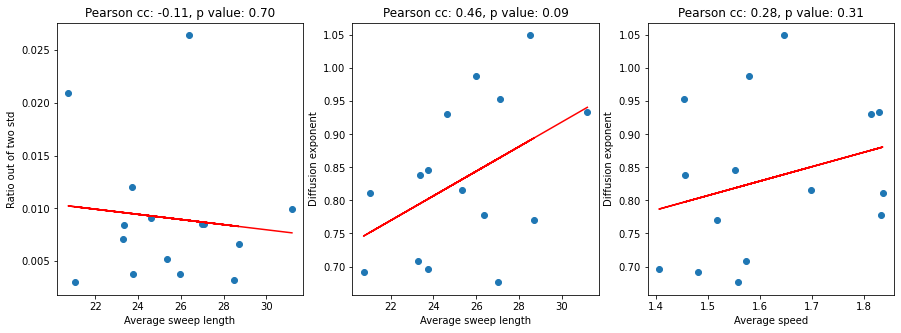

In [20]:
#plot sweep_len against replay_ratio, and against exponent1
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(np.array(sweep_len1), np.array(replay_ratio1))
plt.xlabel('Average sweep length')
plt.ylabel('Ratio out of two std')
#add linear fit line to the plot using numpy.polyfit
slope, intercept = np.polyfit(np.array(sweep_len1), np.array(replay_ratio1), 1)
plt.plot(np.array(sweep_len1), np.array(sweep_len1)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len1), np.array(replay_ratio1))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))
    
plt.subplot(1,3,2)
plt.scatter(np.array(sweep_len1), np.array(exponent1))
plt.xlabel('Average sweep length')
plt.ylabel('Diffusion exponent')
#add linear fit line to the plot
slope, intercept = np.polyfit(np.array(sweep_len1), np.array(exponent1), 1)
plt.plot(np.array(sweep_len1), np.array(sweep_len1)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len1), np.array(exponent1))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))

#plot exponent against average speed
plt.subplot(1,3,3)
plt.scatter(np.array(ave_speed1), np.array(exponent1))
plt.xlabel('Average speed')
plt.ylabel('Diffusion exponent')
#add linear fit line to the plot
slope, intercept = np.polyfit(np.array(ave_speed1), np.array(exponent1), 1)
plt.plot(np.array(ave_speed1), np.array(ave_speed1)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(ave_speed1), np.array(exponent1))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))

plt.show()

## ANalysis for animal fra

In [33]:
def get_sweep_and_replay_results(epoch_key, datadir):
    '''
    Get the average sweep length and replay exponent for one epoch
    '''
    
    #1, LOAD THETA SWEEPS RESULTS
    #load the classifier results
    cv_classifier_clusterless_results = xr.open_dataset(os.path.join(DATA_DIR, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc'))
    #load the data with pickle
    with open(os.path.join(DATA_DIR, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_speed_info.pkl'), 'rb') as f:
        speed = pickle.load(f)
        speed = speed.values
    
    #get the average sweep length
    #extract speed from data and threshold it with 10 cm/s
    is_running = speed > 4

    sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]
    
    #get mean speed with speed < 4 (mean speed udring immobile state)
    mean_immobile_speed = np.mean(speed[speed<4])
    
    mean_sweep_dist = np.mean(sweeps_dist_in_running).values
    
    #2, LOAD REPLAY RESULTS
    #load the dictionary from the 'ReplayTrajectories' folder under PROCESSED_DATA_DIR using pickle
    with open(os.path.join(DATA_DIR, 'ReplayTrajectories', f'{animal}_{day:02d}_{epoch:02d}_traj.pkl'), 'rb') as f:
        Replay_traj = pickle.load(f)
        
    #fig, ax, slope = get_exponent(Replay_traj, plot=True)
    replay_exponent = get_diffusion_exponent(Replay_traj, plot=False)
        
    return mean_immobile_speed, mean_sweep_dist, replay_exponent
    

In [21]:
is_animal = epoch_info.index.isin(['fra'], level='animal')

valid_epochs = (is_w_track &
                (epoch_info.n_neurons > MIN_N_NEURONS) &
                is_animal
                )

DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

sweep_len2 = []
exponent2 = []
ave_speed2 = []
for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
    animal, day, epoch = epoch_key
    print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
    
    #get the average sweep length and replay exponent
    mean_immobile_speed, mean_sweep_dist, replay_exponent = get_sweep_and_replay_results(epoch_key, DATA_DIR)

    #print the average sweep length and replay exponent in one line
    print(f'Average sweep length: {mean_sweep_dist}, Super-diffusion exponent: {replay_exponent}')

    ave_speed2.append(mean_speed)
    sweep_len2.append(np.mean(sweeps_dist_in_running).values)
    exponent2.append(slope)

        

epochs:   0%|          | 0/27 [00:00<?, ?it/s]

Animal: fra, Day: 4, Epoch: 2
Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(20.0924687)
Ratio of steps that are out of two standard deviations: 0.015873015873015872
Animal: fra, Day: 4, Epoch: 4
Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(17.05884613)
Ratio of steps that are out of two standard deviations: 0.015736766809728183
Animal: fra, Day: 4, Epoch: 6
Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(18.62762777)
Ratio of steps that are out of two standard deviations: 0.03677986329608333
Animal: fra, Day: 5, Epoch: 2
Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(29.3198001)
Ratio of steps that are out of two standard deviations: 0.019909502262443438
Animal: fra, Day: 5, Epoch: 4
Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(22.49769975)
Ratio of steps that are out of two 

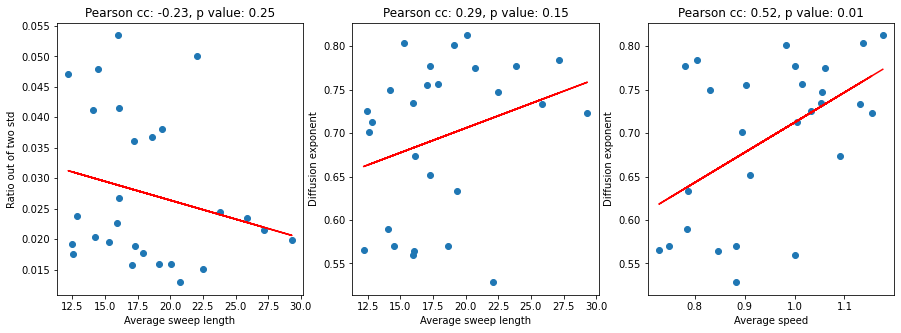

In [22]:
#plot sweep_len against replay_ratio, and against exponent1

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(np.array(sweep_len2), np.array(replay_ratio2))
plt.xlabel('Average sweep length')
plt.ylabel('Ratio out of two std')
#add linear fit line to the plot using numpy.polyfit
slope, intercept = np.polyfit(np.array(sweep_len2), np.array(replay_ratio2), 1)
plt.plot(np.array(sweep_len2), np.array(sweep_len2)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len2), np.array(replay_ratio2))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))
    
plt.subplot(1,3,2)
plt.scatter(np.array(sweep_len2), np.array(exponent2))
plt.xlabel('Average sweep length')
plt.ylabel('Diffusion exponent')
#add linear fit line to the plot
slope, intercept = np.polyfit(np.array(sweep_len2), np.array(exponent2), 1)
plt.plot(np.array(sweep_len2), np.array(sweep_len2)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len2), np.array(exponent2))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))

#plot exponent against average speed
plt.subplot(1,3,3)
plt.scatter(np.array(ave_speed2), np.array(exponent2))
plt.xlabel('Average speed')
plt.ylabel('Diffusion exponent')
#add linear fit line to the plot
slope, intercept = np.polyfit(np.array(ave_speed2), np.array(exponent2), 1)
plt.plot(np.array(ave_speed2), np.array(ave_speed2)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(ave_speed2), np.array(exponent2))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))

plt.show()

### anailysis for animal bon

In [23]:
is_animal = epoch_info.index.isin(['bon'], level='animal')

valid_epochs = (is_w_track &
                (epoch_info.n_neurons > MIN_N_NEURONS) &
                is_animal
                )

DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

sweep_len3 = []
replay_ratio3 = []
exponent3 = []
ave_speed3 = []
for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
    animal, day, epoch = epoch_key
    print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
    
    #1, LOAD THETA SWEEPS RESULTS
    
    #load the classifier results
    cv_classifier_clusterless_results = xr.open_dataset(os.path.join(DATA_DIR, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc'))
    #load the data with pickle
    with open(os.path.join(DATA_DIR, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_speed_info.pkl'), 'rb') as f:
        speed = pickle.load(f)
        speed = speed.values
        
    #get the average sweep length
    #extract speed from data and threshold it with 10 cm/s
    is_running = speed > 4

    sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

    #print the average sweep length
    print(f'Average sweep length: {np.mean(sweeps_dist_in_running)}')
    
    if np.mean(sweeps_dist_in_running).values > 40:
        continue
    
    #get mean speed with speed < 4
    mean_speed = np.mean(speed[speed<4])
    ave_speed3.append(mean_speed)
    
    sweep_len3.append(np.mean(sweeps_dist_in_running).values)
    
    #2, LOAD REPLAY RESULTS
    #load the dictionary from the 'ReplayTrajectories' folder under PROCESSED_DATA_DIR using pickle
    with open(os.path.join(DATA_DIR, 'ReplayTrajectories', f'{animal}_{day:02d}_{epoch:02d}_traj.pkl'), 'rb') as f:
        Replay_traj = pickle.load(f)
        
    #fig, ax, slope = get_exponent(Replay_traj, plot=True)
    slope = get_exponent(Replay_traj, plot=False)
    exponent3.append(slope)
    #plt.show()
        
    steps = get_steps(Replay_traj, timeb=1)
    
    #Count the ratio of steps that are out of three standard deviations
    #get the mean and standard deviation of the steps
    mean = np.mean(steps)
    std = np.std(steps)
    #get the number of steps that are out of three standard deviations
    n_outlier = np.sum(np.abs(steps-mean)>2*std)
    #get the ratio and print mean and standard deviation as well
    ratio = n_outlier/len(steps)
    print(f'Ratio of steps that are out of two standard deviations: {ratio}')
    
    replay_ratio3.append(ratio)
        
        

epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Animal: bon, Day: 3, Epoch: 2
Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(28.69397388)
Ratio of steps that are out of two standard deviations: 0.018780620577027764
Animal: bon, Day: 3, Epoch: 4
Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(15.45233669)
Ratio of steps that are out of two standard deviations: 0.01512491559756921
Animal: bon, Day: 3, Epoch: 6
Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(22.76364045)
Ratio of steps that are out of two standard deviations: 0.05871754975022521
Animal: bon, Day: 4, Epoch: 2
Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(18.43834593)
Ratio of steps that are out of two standard deviations: 0.015470348498710804
Animal: bon, Day: 4, Epoch: 4
Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(17.51475031)
Ratio of steps that are out of two

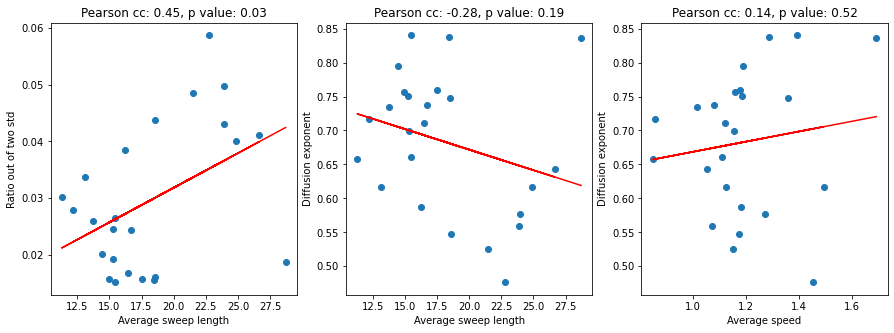

In [24]:

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(np.array(sweep_len3), np.array(replay_ratio3))
plt.xlabel('Average sweep length')
plt.ylabel('Ratio out of two std')
#add linear fit line to the plot using numpy.polyfit
slope, intercept = np.polyfit(np.array(sweep_len3), np.array(replay_ratio3), 1)
plt.plot(np.array(sweep_len3), np.array(sweep_len3)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len3), np.array(replay_ratio3))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))
    
plt.subplot(1,3,2)
plt.scatter(np.array(sweep_len3), np.array(exponent3))
plt.xlabel('Average sweep length')
plt.ylabel('Diffusion exponent')
#add linear fit line to the plot
slope, intercept = np.polyfit(np.array(sweep_len3), np.array(exponent3), 1)
plt.plot(np.array(sweep_len3), np.array(sweep_len3)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len3), np.array(exponent3))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))

#plot exponent against average speed
plt.subplot(1,3,3)
plt.scatter(np.array(ave_speed3), np.array(exponent3))
plt.xlabel('Average speed')
plt.ylabel('Diffusion exponent')
#add linear fit line to the plot
slope, intercept = np.polyfit(np.array(ave_speed3), np.array(exponent3), 1)
plt.plot(np.array(ave_speed3), np.array(ave_speed3)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(ave_speed3), np.array(exponent3))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))

plt.show()

## Analysis for animal gov

In [25]:
is_animal = epoch_info.index.isin(['gov'], level='animal')

valid_epochs = (is_w_track &
                (epoch_info.n_neurons > MIN_N_NEURONS) &
                is_animal
                )

DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

sweep_len4 = []
replay_ratio4 = []
exponent4 = []
ave_speed4 = []
for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
    animal, day, epoch = epoch_key
    print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
    
    #1, LOAD THETA SWEEPS RESULTS
    
    #load the classifier results
    cv_classifier_clusterless_results = xr.open_dataset(os.path.join(DATA_DIR, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc'))
    #load the data with pickle
    with open(os.path.join(DATA_DIR, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_speed_info.pkl'), 'rb') as f:
        speed = pickle.load(f)
        speed = speed.values
        
    #get the average sweep length
    #extract speed from data and threshold it with 10 cm/s
    is_running = speed > 4

    sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

    #print the average sweep length
    print(f'Average sweep length: {np.mean(sweeps_dist_in_running)}')
    
    if np.mean(sweeps_dist_in_running).values > 40:
        continue
    
    #get mean speed with speed < 4
    mean_speed = np.mean(speed[speed<4])
    ave_speed4.append(mean_speed)
    
    sweep_len4.append(np.mean(sweeps_dist_in_running).values)
    
    #2, LOAD REPLAY RESULTS
    #load the dictionary from the 'ReplayTrajectories' folder under PROCESSED_DATA_DIR using pickle
    with open(os.path.join(DATA_DIR, 'ReplayTrajectories', f'{animal}_{day:02d}_{epoch:02d}_traj.pkl'), 'rb') as f:
        Replay_traj = pickle.load(f)
        
    #fig, ax, slope = get_exponent(Replay_traj, plot=True)
    slope = get_exponent(Replay_traj, plot=False)
    exponent4.append(slope)
    #plt.show()
        
    steps = get_steps(Replay_traj, timeb=1)
    
    #Count the ratio of steps that are out of three standard deviations
    #get the mean and standard deviation of the steps
    mean = np.mean(steps)
    std = np.std(steps)
    #get the number of steps that are out of three standard deviations
    n_outlier = np.sum(np.abs(steps-mean)>2*std)
    #get the ratio and print mean and standard deviation as well
    ratio = n_outlier/len(steps)
    print(f'Ratio of steps that are out of two standard deviations: {ratio}')
    
    replay_ratio4.append(ratio)
        
        

epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Animal: gov, Day: 6, Epoch: 2
Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(42.18078441)
Animal: gov, Day: 6, Epoch: 4
Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(38.53839893)
Ratio of steps that are out of two standard deviations: 0.02152439923337756
Animal: gov, Day: 6, Epoch: 6
Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(31.10221201)
Ratio of steps that are out of two standard deviations: 0.02182714310860764
Animal: gov, Day: 7, Epoch: 2
Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(30.09715614)
Ratio of steps that are out of two standard deviations: 0.0145426114151681
Animal: gov, Day: 7, Epoch: 4
Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(23.37393559)
Ratio of steps that are out of two standard deviations: 0.018623024830699775
Animal: gov, Day: 7, Epoch: 6
Averag

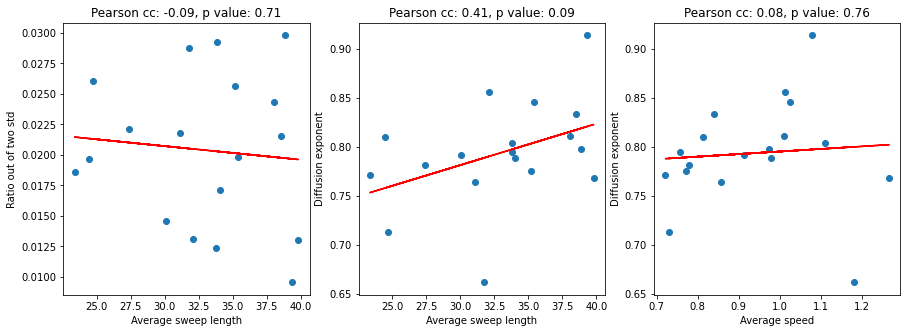

In [26]:

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(np.array(sweep_len4), np.array(replay_ratio4))
plt.xlabel('Average sweep length')
plt.ylabel('Ratio out of two std')
#add linear fit line to the plot using numpy.polyfit
slope, intercept = np.polyfit(np.array(sweep_len4), np.array(replay_ratio4), 1)
plt.plot(np.array(sweep_len4), np.array(sweep_len4)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len4), np.array(replay_ratio4))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))
    
plt.subplot(1,3,2)
plt.scatter(np.array(sweep_len4), np.array(exponent4))
plt.xlabel('Average sweep length')
plt.ylabel('Diffusion exponent')
#add linear fit line to the plot
slope, intercept = np.polyfit(np.array(sweep_len4), np.array(exponent4), 1)
plt.plot(np.array(sweep_len4), np.array(sweep_len4)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len4), np.array(exponent4))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))

#plot exponent against average speed
plt.subplot(1,3,3)
plt.scatter(np.array(ave_speed4), np.array(exponent4))
plt.xlabel('Average speed')
plt.ylabel('Diffusion exponent')
#add linear fit line to the plot
slope, intercept = np.polyfit(np.array(ave_speed4), np.array(exponent4), 1)
plt.plot(np.array(ave_speed4), np.array(ave_speed4)*slope+intercept, 'r-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(ave_speed4), np.array(exponent4))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))

plt.show()

## Analysis for animal dud

In [29]:
is_animal = epoch_info.index.isin(['dud'], level='animal')

valid_epochs = (is_w_track &
                (epoch_info.n_neurons > MIN_N_NEURONS) &
                is_animal
                )

DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

sweep_len5 = []
replay_ratio5 = []
exponent5 = []
ave_speed5 = []
for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
    animal, day, epoch = epoch_key
    print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
    
    #1, LOAD THETA SWEEPS RESULTS
    
    #load the classifier results
    cv_classifier_clusterless_results = xr.open_dataset(os.path.join(DATA_DIR, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc'))
    #load the data with pickle
    with open(os.path.join(DATA_DIR, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_speed_info.pkl'), 'rb') as f:
        speed = pickle.load(f)
        speed = speed.values
        
    #get the average sweep length
    #extract speed from data and threshold it with 10 cm/s
    is_running = speed > 4

    sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

    #print the average sweep length
    print(f'Average sweep length: {np.mean(sweeps_dist_in_running)}')
    
    if np.mean(sweeps_dist_in_running).values > 40:
        continue
    
    #get mean speed with speed < 4
    mean_speed = np.mean(speed[speed<4])
    ave_speed5.append(mean_speed)
    
    sweep_len5.append(np.mean(sweeps_dist_in_running).values)
    
    #2, LOAD REPLAY RESULTS
    #load the dictionary from the 'ReplayTrajectories' folder under PROCESSED_DATA_DIR using pickle
    with open(os.path.join(DATA_DIR, 'ReplayTrajectories', f'{animal}_{day:02d}_{epoch:02d}_traj.pkl'), 'rb') as f:
        Replay_traj = pickle.load(f)
        
    #fig, ax, slope = get_exponent(Replay_traj, plot=True)
    slope = get_exponent(Replay_traj, plot=False)
    exponent5.append(slope)
    #plt.show()
        
    steps = get_steps(Replay_traj, timeb=1)
    
    #Count the ratio of steps that are out of three standard deviations
    #get the mean and standard deviation of the steps
    mean = np.mean(steps)
    std = np.std(steps)
    #get the number of steps that are out of three standard deviations
    n_outlier = np.sum(np.abs(steps-mean)>2*std)
    #get the ratio and print mean and standard deviation as well
    ratio = n_outlier/len(steps)
    print(f'Ratio of steps that are out of two standard deviations: {ratio}')
    
    replay_ratio5.append(ratio)
        
        

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Animal: dud, Day: 2, Epoch: 2
Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(51.26793086)
Animal: dud, Day: 5, Epoch: 2
Average sweep length: <xarray.DataArray 'mental_distance_from_actual_position' ()>
array(41.50920346)


## Analysis for all

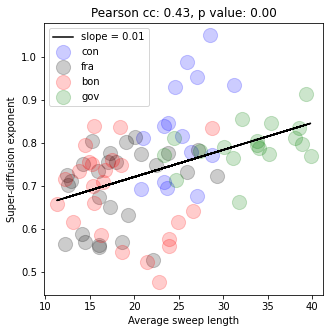

In [27]:
#plot sweep_len against replay_ratio, each with different color
plt.figure(figsize=(5,5))
plt.scatter(np.array(sweep_len1), np.array(exponent1), s=200, color='blue', alpha=0.2, label='con')
plt.scatter(np.array(sweep_len2), np.array(exponent2), s=200, color='black', alpha=0.2, label='fra')
plt.scatter(np.array(sweep_len3), np.array(exponent3), s=200, color='red', alpha=0.2, label='bon')
plt.scatter(np.array(sweep_len4), np.array(exponent4), s=200, color='green', alpha=0.2, label='gov')
#run a linear fit for all the data
slope, intercept = np.polyfit(np.array(sweep_len1+sweep_len2+sweep_len3+sweep_len4), np.array(exponent1+exponent2+exponent3+exponent4), 1)
#plot the linear fit line
plt.plot(np.array(sweep_len1+sweep_len2+sweep_len3+sweep_len4), np.array(sweep_len1+sweep_len2+sweep_len3+sweep_len4)*slope+intercept, 'k-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.array(sweep_len1+sweep_len2+sweep_len3+sweep_len4), np.array(exponent1+exponent2+exponent3+exponent4))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))
plt.xlabel('Average sweep length')
plt.ylabel('Super-diffusion exponent')
plt.legend()
plt.show()

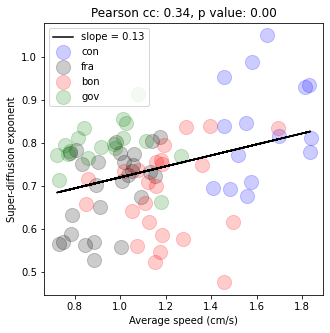

In [28]:
#plot sweep_len against replay_ratio, each with different color
plt.figure(figsize=(5,5))
plt.scatter(np.array(ave_speed1), np.array(exponent1), s=200, color='blue', alpha=0.2, label='con')
plt.scatter(np.array(ave_speed2), np.array(exponent2), s=200, color='black', alpha=0.2, label='fra')
plt.scatter(np.array(ave_speed3), np.array(exponent3), s=200, color='red', alpha=0.2, label='bon')
plt.scatter(np.array(ave_speed4), np.array(exponent4), s=200, color='green', alpha=0.2, label='gov')
#run a linear fit to all three data sets
slope, intercept = np.polyfit(np.concatenate((np.array(ave_speed1), np.array(ave_speed2), np.array(ave_speed3), np.array(ave_speed4))), np.concatenate((np.array(exponent1), np.array(exponent2), np.array(exponent3), np.array(exponent4))), 1)
#plot the linear fit
plt.plot(np.concatenate((np.array(ave_speed1), np.array(ave_speed2), np.array(ave_speed3), np.array(ave_speed4))), np.concatenate((np.array(ave_speed1), np.array(ave_speed2), np.array(ave_speed3), np.array(ave_speed4)))*slope+intercept, 'k-', label='slope = %.2f'%slope)
#pearson test
corr, p = pearsonr(np.concatenate((np.array(ave_speed1), np.array(ave_speed2), np.array(ave_speed3), np.array(ave_speed4))), np.concatenate((np.array(exponent1), np.array(exponent2), np.array(exponent3), np.array(exponent4))))
plt.title('Pearson cc: %.2f, p value: %.2f'%(corr, p))
plt.xlabel('Average speed (cm/s)')
plt.ylabel('Super-diffusion exponent')
plt.legend()
plt.show()



4.448146597772741e-05